##### NOTE: In the previous homeworks, we had to deal with a number of complications which made the grading process unnecessarily harder.  While some were a result of us not making explicit requests about programming practices, others were a result of students not following explicit instructions.  Most of these are very easy for each of you to address individually, while they end up piling up on our end.  Before submitting, make sure you are adhering to the following rules, which helps us grade your assignment.  Each rule is associated with a penalty.

 * (-1pts) Make sure your notebook only contains the exercises requested in the notebook, and the written homework (if any) is delivered in class in printed form, i.e. don't submit your written homework as part of the notebook.
 * (-1pts) Make sure you are using Python3.  This notebook is already set up to use Python3 (top right corner);  Do not change this.
 * (-1pts) If a method is provided with a specific signature, do not change the signature in any way, or the default values.
 * (-1pts) Don't hard-code your solutions to the specific environments which it is being used on, or the specific hyper-parameters which it is being used on;  Be as general as possible, which means also using ALL the arguments of the methods your are implementing.
 * (-1pts) Make sure your submission file follows the format indicated in blackboard and, most importantly, contains your name.
 * (-1pts) Clean up your code before submitting, i.e. remove all print statements that you've used to develop and debug (especially if it's going to clog up the interface by printing thousands of lines).  Only output whatever is required by the exercise.
 * (-2pts) For technical reasons, plots should be contained in their own cell which should run instantly, separate from cells which perform longer computations.  This notebook is already formatted in such a way, please make sure this remains the case.
 * (-5pts or more) Make sure your notebook runs completely, from start to end, without raising any unintended errors.  After you've made the last edit, Use the option `Kernel -> Restart & Run All` to rerun the entire notebook.  If you end up making ANY edit, re-run everything again.  Always assume any edit you make may have broken your code!  About 10% of the previous homeworks would not run from start to end until something was fixed, which represented a huge effort for the grading process.

# Homework 5: TD Learning

In this assignment you will implement Sarsa, Expected Sarsa, and Q-Learning and test these algorithms on the Frozen-lake environment and a Cartpole environment with a discrete state space.

In [1]:
import numpy as np
import numpy.random as rnd
import matplotlib.pyplot as plt
import copy
from collections import defaultdict
from more_itertools import windowed
import tqdm

from gym import ObservationWrapper
from gym.envs.toy_text.frozen_lake import FrozenLakeEnv
from gym.envs.classic_control.cartpole import CartPoleEnv

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 18, 6

## Misc Utilities

Some are provided, some you should implement

### Smoothing

In this homework, we'll do some plotting of noisy data, so here is the smoothing function which was also used in the previous homework.

In [2]:
def rolling_average(data, *, window_size):
    """Smoothen the 1-d data array using a rollin average.
    
    Args:
        data: 1-d numpy.array
        window_size: size of the smoothing window
        
    Returns:
        smooth_data: a 1-d numpy.array with the same size as data
    """
    assert data.ndim == 1
    kernel = np.ones(window_size)
    smooth_data = np.convolve(data, kernel) / np.convolve(np.ones_like(data), kernel)
    return smooth_data[: -window_size + 1]

### $\epsilon$-Greedy Action Selection

Since you've implemented this method in the previous homework, I'll cut you some slack and provide it for you =)

In [3]:
def select_action_epsilon_greedy(Q_array, *, eps):
    """Perform epsilon greedy action selection based on the Q-values.

    :param Q_array: A numpy array that contains Q-values relative to a single state.
    :param eps: The probability to select a random action. Float between 0 and 1.

    Shapes:
        Q_array: `(A,)` where `A` is the number of actions.
        output: Scalar.
    """
    assert Q_array.ndim == 1

    if rnd.rand() < eps:
        num_actions = Q_array.shape[0]
        action = rnd.randint(num_actions)
    else:
        actions_maximal = np.argwhere(Q_array == Q_array.max()).flatten()  # all maximal actions
        action = rnd.choice(actions_maximal)

    return action

### $\epsilon$-Greedy Decay

A fairly typical thing to do when using a $\epsilon$-greedy exploration strategy is to anneal $\epsilon$ from its starting value to some final value over a number of timesteps. This allows your agent to explore the environment more at the beginning of training, and less later on.  If the method we are implementing requires an $\epsilon$-soft policy, then you should not anneal the $\epsilon$ to zero.

In [4]:
class LinearSchedule:
    def __init__(self, value_from, value_to, nsteps):
        """Linear schedule from `value_from` to `value_to` in `nsteps` steps.

        :param value_from: initial value
        :param value_to: final value
        :param nsteps: number of steps for the linear schedule
        """
        self.value_from = value_from
        self.value_to = value_to
        self.nsteps = nsteps

    def value(self, step) -> float:
        """Return interpolated value between `value_from` and `value_to`.

        returns {
            `value_from`, if step == 0 or less
            `value_to`, if step == nsteps - 1 or more
            the interpolation between `value_from` and `value_to`, if 0 <= steps < nsteps
        }

        :param step:  The step at which to compute the interpolation.
        :rtype: float.  The interpolated value.
        """

        # YOUR CODE HERE (use the tests below if you need examples of what this should produce.)
        
        if step < 0: step = 0
        elif step > self.nsteps - 1: step = self.nsteps - 1
        value = self.value_from + (self.value_to - self.value_from) * (step / (self.nsteps - 1))
        
        return value


# test code, do not edit


def _test_schedule(schedule, step, value, ndigits=5):
    """Tests that the schedule returns the correct value."""
    v = schedule.value(step)
    if not round(v, ndigits) == value:
        raise Exception(f'For step {step}, the scheduler returned {v} instead of {value}')


_schedule = LinearSchedule(0.1, 0.2, 3)
_test_schedule(_schedule, -1, 0.1)
_test_schedule(_schedule, 0, 0.1)
_test_schedule(_schedule, 1, 0.15)
_test_schedule(_schedule, 2, 0.2)
_test_schedule(_schedule, 3, 0.2)
del _schedule

_schedule = LinearSchedule(0.5, 0.0, 6)
_test_schedule(_schedule, -1, 0.5)
_test_schedule(_schedule, 0, 0.5)
_test_schedule(_schedule, 1, 0.4)
_test_schedule(_schedule, 2, 0.3)
_test_schedule(_schedule, 3, 0.2)
_test_schedule(_schedule, 4, 0.1)
_test_schedule(_schedule, 5, 0.0)
_test_schedule(_schedule, 6, 0.0)
del _schedule

### Discrete CartPole

In this homework we will use a new environment called CartPole (see [here](https://github.com/openai/gym/wiki/CartPole-v0)).  This is a very popular environment, often used as benchmark to make sure that new methods work on simple domains.

Compared to the Frozen Lake environment, this one has *continuous* states.  So far we have only addressed the case of discrete states and actions;  as a result, all of the methods we have seen so far have been "tabular", i.e. they used dictionaries / hash-maps to store policies and values.  This is not possible for continuous states because, among other reasons, it is often virtually impossible to visit the exact same state twice.  We will formally address the problem of continuous states later in the course, using function approximators.  In the meantime, we will create a gym.Wrapper which discretizes the observed states (a.k.a observations).  Generally, the finer the discretization the more optimal your policy will be but the longer it will take to train.

In [5]:
class DiscreteWrapper(ObservationWrapper):
    def __init__(self, env, decimals):
        super().__init__(env)
        self.decimals = decimals

    def observation(self, observation):
        return tuple(observation.round(self.decimals))


frozen_lake = FrozenLakeEnv(map_name='4x4', is_slippery=False)
frozen_lake_slippery = FrozenLakeEnv(map_name='4x4', is_slippery=True)
cartpole_discrete = DiscreteWrapper(CartPoleEnv(), decimals=1)

## Exercise 1 (30 Points):

#### a) Implement the on-policy TD control algorithm known as SARSA.  <font color='red'>??? Make sure that the exploration schedule is applied based on how many time-steps have passed from the beginning of the training, not the beginning of the episode!??? </font>

In [6]:
def sarsa(env, num_episodes, num_steps_max, *, alpha, gamma, exploration):
    """SARSA algorithm.

    Args:
        - env: The Gym environment
        - num_episodes: The number of episodes for which to train the agent
        - num_steps_max: The maximum number of steps for a single episode
        - alpha: The stepsize
        - gamma: The discount factor
        - exploration: epsilon schedule

    Returns: (Q, returns, lengths)
        - Q: Dictonary mapping state -> action values
        - returns: Numpy array containing the reward of each episode during training
        - lengths: Numpy array containing the length of each episode during training
    """
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    returns = np.empty(num_episodes)
    lengths = np.empty(num_episodes, dtype=np.int)

    for i in tqdm.tnrange(num_episodes, desc='Episodes', leave=False):
        # YOUR CODE HERE
        
        # FEEDBACK: -2 pts. you're applying the decay at the episode level, not the time-step level as requested.
        epsilon = exploration.value(i)
        state = env.reset()
        action = select_action_epsilon_greedy(Q[state], eps=epsilon)
        return_i = 0.
        for t in np.arange(0, num_steps_max):
            next_state, reward, done, _ = env.step(action)
            next_action = select_action_epsilon_greedy(Q[next_state], eps=epsilon)
            Q[state][action] += alpha * (reward + gamma * Q[next_state][next_action] - Q[state][action])
            state = next_state
            action = next_action
            return_i = reward + gamma * return_i  # FEEDBACK: -2 pts. your discounting is wrong; you're discounting early rewards more than latter ones.
#             return_i = reward ** t * reward + return_i
            if done: break
        returns[i] = return_i
        lengths[i] = t

    return Q, returns, lengths

#### b) Test your implentation of SARSA on the non-slippery FrozenLake environment with $\gamma=1.0$.  Find the best $\alpha$ and exploration strategy.  Plot the episode returns and episode lengths over number of training episodes.

It might be helpful to also smooth the curves to get a clearer picture of the learning process.  If you do so, plot both the unsmoothened data and the smoothened data in the same figure, and remember to label the axes and the lines.  Make your plots readable **without having to look at your code**.

In [7]:
# hint:  you may temporarily change these values to help development, but make sure you set them back before submitting!
num_runs, num_episodes, num_steps_max = 50, 1_000, 100
returns_sarsa_fl = np.empty((num_runs, num_episodes))
lengths_sarsa_fl = np.empty((num_runs, num_episodes), dtype=np.int)

for i in tqdm.tnrange(num_runs, desc='Runs'):
    # YOUR CODE HERE
    
    exploration = LinearSchedule(1, 0, 50)
    # FEEDBACK: alpha 0.5 is extremely high; it makes your estimates forget about previous returns very quickly.
    # it's going to be less of an issue for very deterministic domains; but very much of a problem for stochastic ones.
    _, returns_sarsa_fl[i], lengths_sarsa_fl[i] = sarsa(frozen_lake, num_episodes, num_steps_max,
                                                        alpha=0.5, gamma=1., exploration=exploration)

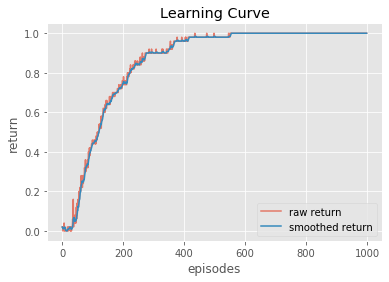

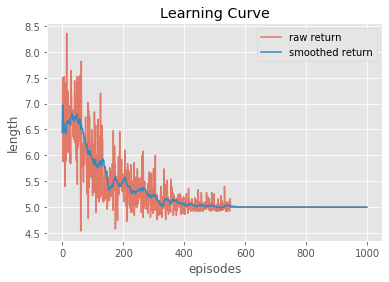

In [8]:
# YOUR PLOTS HERE

plt.figure()
returns_sarsa_fl_mean = returns_sarsa_fl.mean(0)
plt.plot(returns_sarsa_fl_mean, alpha=0.7)
plt.plot(rolling_average(returns_sarsa_fl_mean, window_size=5))
plt.legend(['raw return', 'smoothed return'])
plt.xlabel('episodes')
plt.ylabel('return')
plt.title('Learning Curve')
plt.show()

plt.figure()
lengths_sarsa_fl_mean = lengths_sarsa_fl.mean(0)
plt.plot(lengths_sarsa_fl_mean, alpha=0.7)
plt.plot(rolling_average(lengths_sarsa_fl_mean, window_size=20))
plt.legend(['raw return', 'smoothed return'])
plt.xlabel('episodes')
plt.ylabel('length')
plt.title('Learning Curve')
plt.show()

#### [graduate, 5 pts] The non-slippery FrozenLake environment is deterministic, and we are applying no discounting to the rewards ($\gamma=1.0$);  this means that there is no incentive to exit quickly, and an optimal policy can wander around indefinitely as long as it eventually exits.  However, you should notice in your plots a negative correlation between episode return and episode length, indicating that good performance in your learned policy is somehow associated with shorter episodes.  Explain this apparent contradiction.

YOUR ANSWER HERE _I think in the non-slippery FrozenLake, a leaned optimal policy can go to goal efficently, whereas the initial policy will lead to randon walk. The fact that the leaned policy is a short path may due to the policy is greedy with respect to the Q function. The Q with state near to the goal and action moving to the goal tends to have lager value, then the greedy policy tends to chose it._

#### c) Test your implentation of SARSA on the slippery FrozenLake environment with $\gamma=1.0$.  Find the best $\alpha$ and exploration strategy.  Plot the episode returns and episode lengths over number of training episodes.

It might be helpful to also smooth the curves to get a clearer picture of the learning process.  If you do so, plot both the unsmoothened data and the smoothened data in the same figure, and remember to label the axes and the lines.  Make your plots readable **without having to look at your code**.

In [9]:
# hint:  you may temporarily change these values to help development, but make sure you set them back before submitting!
num_runs, num_episodes, num_steps_max = 10, 20_000, 100
returns_sarsa_fls = np.empty((num_runs, num_episodes))
lengths_sarsa_fls = np.empty((num_runs, num_episodes), dtype=np.int)

for i in tqdm.tnrange(num_runs, desc='Runs'):
    # YOUR CODE HERE
    
    exploration = LinearSchedule(1, 0, 5_000)
    _, returns_sarsa_fls[i], lengths_sarsa_fls[i] = sarsa(frozen_lake_slippery, num_episodes, num_steps_max,
                                                        alpha=0.05, gamma=1., exploration=exploration)

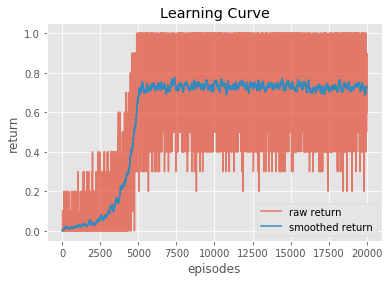

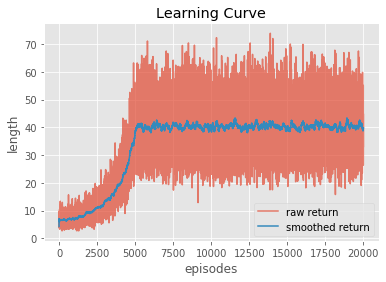

In [10]:
# YOUR PLOTS HERE

plt.figure()
returns_sarsa_fls_mean = returns_sarsa_fls.mean(0)
plt.plot(returns_sarsa_fls_mean, alpha=0.7)
plt.plot(rolling_average(returns_sarsa_fls_mean, window_size=100))
plt.legend(['raw return', 'smoothed return'])
plt.xlabel('episodes')
plt.ylabel('return')
plt.title('Learning Curve')
plt.show()

plt.figure()
lengths_sarsa_fls_mean = lengths_sarsa_fls.mean(0)
plt.plot(lengths_sarsa_fls_mean, alpha=0.7)
plt.plot(rolling_average(lengths_sarsa_fls_mean, window_size=100))
plt.legend(['raw return', 'smoothed return'])
plt.xlabel('episodes')
plt.ylabel('length')
plt.title('Learning Curve')
plt.show()

#### [graduate, 5 pts] In the non-slippery FrozenLake environment, you should notice a negative correlation between return and episode length.  In the slippery FrozenLake environment, you should notice a positive correlation between return and episode length.  Why does this make sense?

YOUR ANSWER HERE _In the slippery situation, SARSA will lean the optimal policy here too. However, due the slippery, the optimal path should be 'safe' to avoid fall into holes, thus would be longer than non-sliperry situation. I think the optimal 'safe' path is even longer than random walk before all into hole, so during learning the length will increasing from random walk till optimal 'safe' path -- 40 steps._

#### d) Test your implentation of SARSA on the discrete CartPole environment with $\gamma=1.0$.  Find the best $\alpha$ and exploration strategy.  Plot the episode returns and episode lengths over number of training episodes.

It might be helpful to also smooth the curves to get a clearer picture of the learning process.  If you do so, plot both the unsmoothened data and the smoothened data in the same figure, and remember to label the axes and the lines.  Make your plots readable **without having to look at your code**.

In [11]:
# hint:  you may temporarily change these values to help development, but make sure you set them back before submitting!
num_runs, num_episodes, num_steps_max = 10, 30_000, 100
returns_sarsa_cpd = np.empty((num_runs, num_episodes))
lengths_sarsa_cpd = np.empty((num_runs, num_episodes), dtype=np.int)

for i in tqdm.tnrange(num_runs, desc='Runs'):
    # YOUR CODE HERE
    
    exploration = LinearSchedule(1, 0, 15_000)
    _, returns_sarsa_cpd[i], lengths_sarsa_cpd[i] = sarsa(cartpole_discrete, num_episodes, num_steps_max,
                                                        alpha=0.1, gamma=1., exploration=exploration)

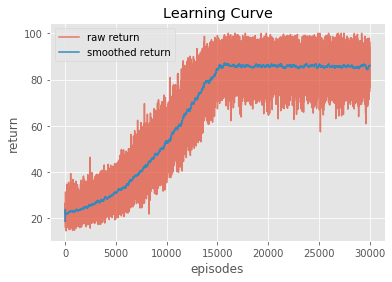

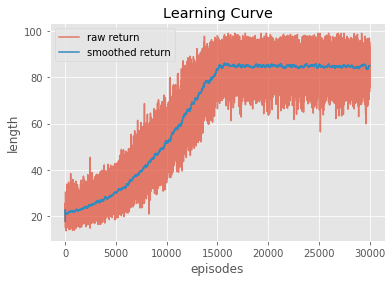

In [12]:
# YOUR PLOTS HERE

plt.figure()
returns_sarsa_cpd_mean = returns_sarsa_cpd.mean(0)
plt.plot(returns_sarsa_cpd_mean, alpha=0.7)
plt.plot(rolling_average(returns_sarsa_cpd_mean, window_size=200))
plt.legend(['raw return', 'smoothed return'])
plt.xlabel('episodes')
plt.ylabel('return')
plt.title('Learning Curve')
plt.show()

plt.figure()
lengths_sarsa_cpd_mean = lengths_sarsa_cpd.mean(0)
plt.plot(lengths_sarsa_cpd_mean, alpha=0.7)
plt.plot(rolling_average(lengths_sarsa_cpd_mean, window_size=200))
plt.legend(['raw return', 'smoothed return'])
plt.xlabel('episodes')
plt.ylabel('length')
plt.title('Learning Curve')
plt.show()

## Exercise 2 (20 Points):

#### a) Implement the on-policy TD control algorithm known as Expected-SARSA. Make sure that the exploration schedule is applied based on how many time-steps have passed from the beginning of the training, not the beginning of the episode!

In [13]:
def expected_sarsa(
    env, num_episodes, num_steps_max, *, alpha, gamma, exploration
):
    """Expected SARSA algorithm.

    Args:
        - env: The Gym environment
        - num_episodes: The number of episodes for which to train the agent
        - num_steps_max: The maximum number of steps for a single episode
        - alpha: The stepsize
        - gamma: The discount factor
        - exploration: epsilon schedule

    Returns: (Q, returns, lengths)
        - Q: Dictonary mapping state -> action values
        - returns: Numpy array containing the reward of each episode during training
        - lengths: Numpy array containing the length of each episode during training
    """
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    returns = np.empty(num_episodes)
    lengths = np.empty(num_episodes, dtype=np.int)

    for i in tqdm.tnrange(num_episodes, desc='Episodes', leave=False):
        # YOUR CODE HERE
        
        epsilon = exploration.value(i) # FEEDBACK: -1 pts. applying decay at episode level instead of time-step level.
        state = env.reset()
        action = select_action_epsilon_greedy(Q[state], eps=epsilon)
        return_i = 0.
        for t in np.arange(0, num_steps_max):
            next_state, reward, done, _ = env.step(action)
            # FEEDBACK: -2 pts. we don't presample actions in expected sarsa
            next_action = select_action_epsilon_greedy(Q[next_state], eps=epsilon)
            E_Q = (1 - epsilon) * Q[next_state].max() + epsilon * Q[next_state].mean()
            Q[state][action] += alpha * (reward + gamma * E_Q - Q[state][action])
            state = next_state
            action = next_action
            return_i = reward + gamma * return_i  # FEEDBACK: -1 pts. wrong discounting. lower penalty for repeated errors
            if done: break
        returns[i] = return_i
        lengths[i] = t

    return Q, returns, lengths

#### b) Test your implentation of expected-SARSA on the non-slippery FrozenLake environment with $\gamma=1.0$.  Find the best $\alpha$ and exploration strategy.  Plot the episode returns and episode lengths over number of training episodes.

It might be helpful to also smooth the curves to get a clearer picture of the learning process.  If you do so, plot both the unsmoothened data and the smoothened data in the same figure, and remember to label the axes and the lines.  Make your plots readable **without having to look at your code**.

In [14]:
# hint:  you may temporarily change these values to help development, but make sure you set them back before submitting!
num_runs, num_episodes, num_steps_max = 10, 1_000, 100
returns_esarsa_fl = np.empty((num_runs, num_episodes))
lengths_esarsa_fl = np.empty((num_runs, num_episodes), dtype=np.int)

for i in tqdm.tnrange(num_runs, desc='Runs'):
    # YOUR CODE HER
    
    exploration = LinearSchedule(1, 0, 150)
    _, returns_esarsa_fl[i], lengths_esarsa_fl[i] = expected_sarsa(frozen_lake, num_episodes, num_steps_max,
                                                        alpha=0.2, gamma=1., exploration=exploration)

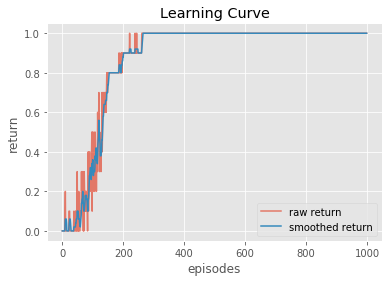

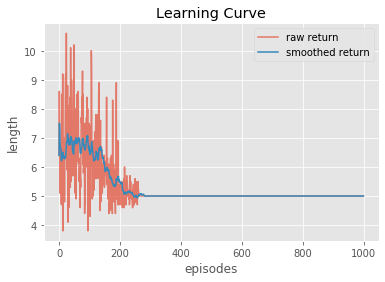

In [15]:
# YOUR PLOTS HERE

plt.figure()
returns_esarsa_fl_mean = returns_esarsa_fl.mean(0)
plt.plot(returns_esarsa_fl_mean, alpha=0.7)
plt.plot(rolling_average(returns_esarsa_fl_mean, window_size=5))
plt.legend(['raw return', 'smoothed return'])
plt.xlabel('episodes')
plt.ylabel('return')
plt.title('Learning Curve')
plt.show()

plt.figure()
lengths_esarsa_fl_mean = lengths_esarsa_fl.mean(0)
plt.plot(lengths_esarsa_fl_mean, alpha=0.7)
plt.plot(rolling_average(lengths_esarsa_fl_mean, window_size=20))
plt.legend(['raw return', 'smoothed return'])
plt.xlabel('episodes')
plt.ylabel('length')
plt.title('Learning Curve')
plt.show()

#### c) Test your implentation of expected-SARSA on the slippery FrozenLake environment with $\gamma=1.0$.  Find the best $\alpha$ and exploration strategy.  Plot the episode returns and episode lengths over number of training episodes.

It might be helpful to also smooth the curves to get a clearer picture of the learning process.  If you do so, plot both the unsmoothened data and the smoothened data in the same figure, and remember to label the axes and the lines.  Make your plots readable **without having to look at your code**.

In [16]:
# hint:  you may temporarily change these values to help development, but make sure you set them back before submitting!
num_runs, num_episodes, num_steps_max = 10, 20_000, 100
returns_esarsa_fls = np.empty((num_runs, num_episodes))
lengths_esarsa_fls = np.empty((num_runs, num_episodes), dtype=np.int)

for i in tqdm.tnrange(num_runs, desc='Runs'):
    # YOUR CODE HERE
    
    exploration = LinearSchedule(1, 0, 3_000)
    _, returns_esarsa_fls[i], lengths_esarsa_fls[i] = expected_sarsa(frozen_lake_slippery, num_episodes, num_steps_max,
                                                                   alpha=0.05, gamma=1., exploration=exploration)

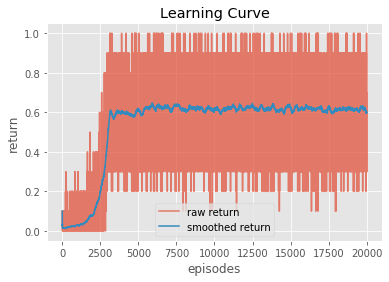

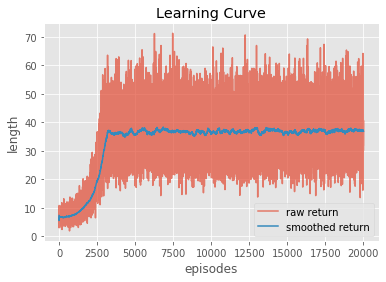

In [17]:
# YOUR PLOTS HERE

plt.figure()
returns_esarsa_fls_mean = returns_esarsa_fls.mean(0)
plt.plot(returns_esarsa_fls_mean, alpha=0.7)
plt.plot(rolling_average(returns_esarsa_fls_mean, window_size=200))
plt.legend(['raw return', 'smoothed return'])
plt.xlabel('episodes')
plt.ylabel('return')
plt.title('Learning Curve')
plt.show()

plt.figure()
lengths_esarsa_fls_mean = lengths_esarsa_fls.mean(0)
plt.plot(lengths_esarsa_fls_mean, alpha=0.7)
plt.plot(rolling_average(lengths_esarsa_fls_mean, window_size=200))
plt.legend(['raw return', 'smoothed return'])
plt.xlabel('episodes')
plt.ylabel('length')
plt.title('Learning Curve')
plt.show()

#### d) Test your implentation of expected-SARSA on the discrete CartPole environment with $\gamma=1.0$.  Find the best $\alpha$ and exploration strategy.  Plot the episode returns and episode lengths over number of training episodes.

It might be helpful to also smooth the curves to get a clearer picture of the learning process.  If you do so, plot both the unsmoothened data and the smoothened data in the same figure, and remember to label the axes and the lines.  Make your plots readable **without having to look at your code**.

In [18]:
# hint:  you may temporarily change these values to help development, but make sure you set them back before submitting!
num_runs, num_episodes, num_steps_max = 10, 30_000, 100
returns_esarsa_cpd = np.empty((num_runs, num_episodes))
lengths_esarsa_cpd = np.empty((num_runs, num_episodes), dtype=np.int)

for i in tqdm.tnrange(num_runs, desc='Runs'):
    # YOUR CODE HERE
    
    exploration = LinearSchedule(1, 0, 30_000)
    _, returns_esarsa_cpd[i], lengths_esarsa_cpd[i] = expected_sarsa(cartpole_discrete, num_episodes, num_steps_max,
                                                        alpha=0.6, gamma=1., exploration=exploration)

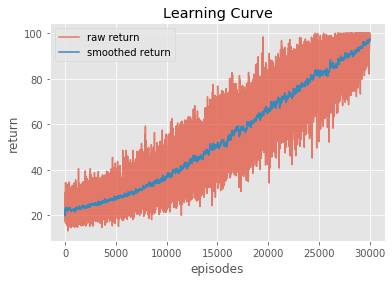

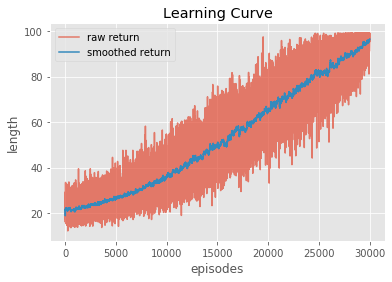

In [19]:
# YOUR PLOTS HERE

plt.figure()
returns_esarsa_cpd_mean = returns_esarsa_cpd.mean(0)
plt.plot(returns_esarsa_cpd_mean, alpha=0.7)
plt.plot(rolling_average(returns_esarsa_cpd_mean, window_size=100))
plt.legend(['raw return', 'smoothed return'])
plt.xlabel('episodes')
plt.ylabel('return')
plt.title('Learning Curve')
plt.show()

plt.figure()
lengths_esarsa_cpd_mean = lengths_esarsa_cpd.mean(0)
plt.plot(lengths_esarsa_cpd_mean, alpha=0.7)
plt.plot(rolling_average(lengths_esarsa_cpd_mean, window_size=100))
plt.legend(['raw return', 'smoothed return'])
plt.xlabel('episodes')
plt.ylabel('length')
plt.title('Learning Curve')
plt.show()

## Exercise 3 (20 Points):

#### a) Implement the off-policy TD control algorithm known as Q-learning. Make sure that the exploration schedule is applied based on how many time-steps have passed from the beginning of the training, not the beginning of the episode!

In [20]:
def q_learning(env, num_episodes, num_steps_max, *, alpha, gamma, exploration):
    """Q-learning algorithm.

    Args:
        - env: The Gym environment
        - num_episodes: The number of episodes for which to train the agent
        - num_steps_max: The maximum number of steps for a single episode
        - alpha: The stepsize
        - gamma: The discount factor
        - exploration: epsilon schedule

    Returns: (Q, returns, lengths)
        - Q: Dictonary mapping state -> action values
        - returns: Numpy array containing the return of each episode during training
        - lengths: Numpy array containing the length of each episode during training
    """
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    returns = np.empty(num_episodes)
    lengths = np.empty(num_episodes, dtype=np.int)

    for i in tqdm.tnrange(num_episodes, desc='Episodes', leave=False):
        # YOUR CODE HERE
        
        epsilon = exploration.value(i)  # FEEDBACK: -1 pts. applying decay at episode level instead of step-level.
        state = env.reset()
        return_i = 0.
        for t in np.arange(0, num_steps_max):
            action = select_action_epsilon_greedy(Q[state], eps=epsilon)
            next_state, reward, done, _ = env.step(action)
            Q[state][action] += alpha * (reward + gamma * Q[next_state].max() - Q[state][action])
            state = next_state
            return_i = reward + gamma * return_i  # FEEDBACK: -1 pts.  wrong discounting
            if done: break
        returns[i] = return_i
        lengths[i] = t

    return Q, returns, lengths

#### b) Test your implentation of Q-learning on the non-slippery FrozenLake environment with $\gamma=1.0$.  Find the best $\alpha$ and exploration strategy.  Plot the episode returns and episode lengths over number of training episodes.

It might be helpful to also smooth the curves to get a clearer picture of the learning process.  If you do so, plot both the unsmoothened data and the smoothened data in the same figure, and remember to label the axes and the lines.  Make your plots readable **without having to look at your code**.

In [21]:
# hint:  you may temporarily change these values to help development, but make sure you set them back before submitting!
num_runs, num_episodes, num_steps_max = 50, 1_000, 100
returns_ql_fl = np.empty((num_runs, num_episodes))
lengths_ql_fl = np.empty((num_runs, num_episodes), dtype=np.int)

for i in tqdm.tnrange(num_runs, desc='Runs'):
    # YOUR CODE HERE
    
    exploration = LinearSchedule(1, 0, 50)
    _, returns_ql_fl[i], lengths_ql_fl[i] = q_learning(frozen_lake, num_episodes, num_steps_max,
                                                        alpha=0.2, gamma=1., exploration=exploration)

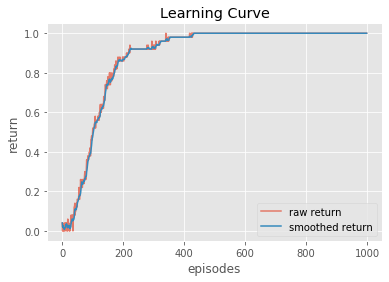

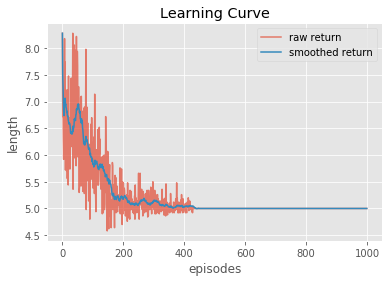

In [22]:
# YOUR PLOTS HERE

plt.figure()
returns_ql_fl_mean = returns_ql_fl.mean(0)
plt.plot(returns_ql_fl_mean, alpha=0.7)
plt.plot(rolling_average(returns_ql_fl_mean, window_size=5))
plt.legend(['raw return', 'smoothed return'])
plt.xlabel('episodes')
plt.ylabel('return')
plt.title('Learning Curve')
plt.show()

plt.figure()
lengths_ql_fl_mean = lengths_ql_fl.mean(0)
plt.plot(lengths_ql_fl_mean, alpha=0.7)
plt.plot(rolling_average(lengths_ql_fl_mean, window_size=20))
plt.legend(['raw return', 'smoothed return'])
plt.xlabel('episodes')
plt.ylabel('length')
plt.title('Learning Curve')
plt.show()

#### c) Test your implentation of Q-learning on the slippery FrozenLake environment with $\gamma=1.0$.  Find the best $\alpha$ and exploration strategy.  Plot the episode returns and episode lengths over number of training episodes.

It might be helpful to also smooth the curves to get a clearer picture of the learning process.  If you do so, plot both the unsmoothened data and the smoothened data in the same figure, and remember to label the axes and the lines.  Make your plots readable **without having to look at your code**.

In [23]:
# hint:  you may temporarily change these values to help development, but make sure you set them back before submitting!
num_runs, num_episodes, num_steps_max = 10, 20_000, 100
returns_ql_fls = np.empty((num_runs, num_episodes))
lengths_ql_fls = np.empty((num_runs, num_episodes), dtype=np.int)

for i in tqdm.tnrange(num_runs, desc='Runs'):
    # YOUR CODE HERE
    
    exploration = LinearSchedule(1, 0, 5_000)
    _, returns_ql_fls[i], lengths_ql_fls[i] = q_learning(frozen_lake_slippery, num_episodes, num_steps_max,
                                                        alpha=0.001, gamma=1., exploration=exploration)

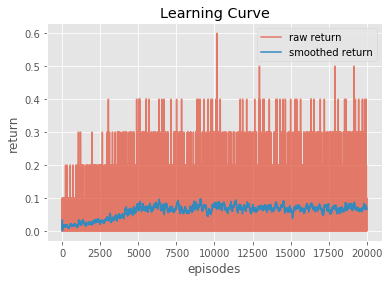

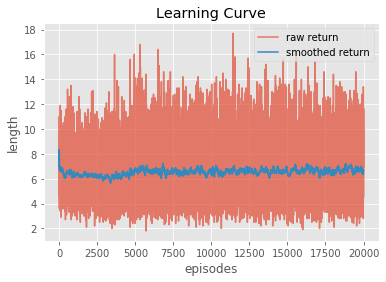

In [24]:
# YOUR PLOTS HERE

plt.figure()
returns_ql_fls_mean = returns_ql_fls.mean(0)
plt.plot(returns_ql_fls_mean, alpha=0.7)
plt.plot(rolling_average(returns_ql_fls_mean, window_size=100))
plt.legend(['raw return', 'smoothed return'])
plt.xlabel('episodes')
plt.ylabel('return')
plt.title('Learning Curve')
plt.show()

plt.figure()
lengths_ql_fls_mean = lengths_ql_fls.mean(0)
plt.plot(lengths_ql_fls_mean, alpha=0.7)
plt.plot(rolling_average(lengths_ql_fls_mean, window_size=100))
plt.legend(['raw return', 'smoothed return'])
plt.xlabel('episodes')
plt.ylabel('length')
plt.title('Learning Curve')
plt.show()

#### d) Test your implentation of Q-learning on the discrete CartPole environment with $\gamma=1.0$.  Find the best $\alpha$ and exploration strategy.  Plot the episode returns and episode lengths over number of training episodes.

It might be helpful to also smooth the curves to get a clearer picture of the learning process.  If you do so, plot both the unsmoothened data and the smoothened data in the same figure, and remember to label the axes and the lines.  Make your plots readable **without having to look at your code**.

In [25]:
# hint:  you may temporarily change these values to help development, but make sure you set them back before submitting!
num_runs, num_episodes, num_steps_max = 10, 30_000, 100
returns_ql_cpd = np.empty((num_runs, num_episodes))
lengths_ql_cpd = np.empty((num_runs, num_episodes), dtype=np.int)

for i in tqdm.tnrange(num_runs, desc='Runs'):
    # YOUR CODE HERE
    
    exploration = LinearSchedule(1, 0, 500)
    _, returns_ql_cpd[i], lengths_ql_cpd[i] = q_learning(cartpole_discrete, num_episodes, num_steps_max,
                                                        alpha=0.01, gamma=1., exploration=exploration)

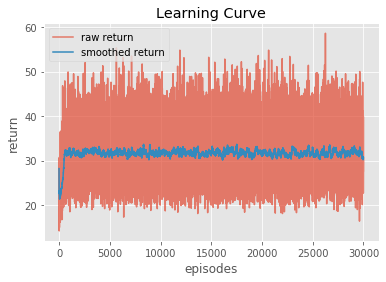

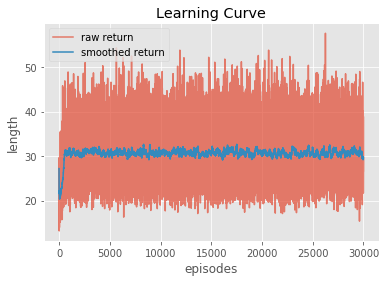

In [26]:
# YOUR PLOTS HERE

plt.figure()
returns_ql_cpd_mean = returns_ql_cpd.mean(0)
plt.plot(returns_ql_cpd_mean, alpha=0.7)
plt.plot(rolling_average(returns_ql_cpd_mean, window_size=100))
plt.legend(['raw return', 'smoothed return'])
plt.xlabel('episodes')
plt.ylabel('return')
plt.title('Learning Curve')
plt.show()

plt.figure()
lengths_ql_cpd_mean = lengths_ql_cpd.mean(0)
plt.plot(lengths_ql_cpd_mean, alpha=0.7)
plt.plot(rolling_average(lengths_ql_cpd_mean, window_size=100))
plt.legend(['raw return', 'smoothed return'])
plt.xlabel('episodes')
plt.ylabel('length')
plt.title('Learning Curve')
plt.show()